# Machine Learning & Statistics Project

# Introduction

We have been tasked with creating a web service that uses machine learning to make predictions based on the data set provided on power production taken from Moodle. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. We must then develop a web service that will respond with predicted power values based on speed values sent as HTTP requests. 

Keras could be used to manage the data. Takes large number of float inputs and provides output

# Introduction

# Wind Power Description



# Explore the data

First we will import the required libraries and start to explore the data to get a feel for what we're dealing with.

In [168]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import sklearn  
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from collections import Counter

#matplotlib inline
rcParams['figure.figsize']=5, 4

# Import the csv file containing the information
df = pd.read_csv('powerproduction.txt')

# Check first 10 rows to ensure we're getting correct data in as first 5 columns power outputt displayed as 0
print(f'{df.head(11)}\n')
print(f'{df.tail(15)}\n')

# Display dataframes information
print(f'{df.info()}\n')
print(f'{df.describe()}\n')
print(f'{df.shape}\n')

print(f'{df.isnull().sum()}\n')
print(f'{df.isna().sum()}')

    speed  power
0   0.000  0.000
1   0.125  0.000
2   0.150  0.000
3   0.225  0.000
4   0.275  0.000
5   0.325  4.331
6   0.400  5.186
7   0.450  3.826
8   0.501  1.048
9   0.526  5.553
10  0.551  6.498

      speed    power
485  24.249  103.700
486  24.299   93.694
487  24.349   93.078
488  24.374   98.223
489  24.399   95.117
490  24.499    0.000
491  24.525    0.000
492  24.575    0.000
493  24.650    0.000
494  24.750    0.000
495  24.775    0.000
496  24.850    0.000
497  24.875    0.000
498  24.950    0.000
499  25.000    0.000

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   speed   500 non-null    float64
 1   power   500 non-null    float64
dtypes: float64(2)
memory usage: 7.9 KB
None

            speed       power
count  500.000000  500.000000
mean    12.590398   48.014584
std      7.224991   41.614572
min      0.000000    0.000000
25%      6

From the above we can see that the information received is 2 colmuns of 500 rows populated by floats. The speed range is 0-25 and the power range  is 0-100. No units are given in this table but for the purpose of this project it will be assumed the speed is measured in m/s and the power is in % of design output.

We can see that at the minimum and maximum speed values there is a value of 0 which is showing us a minimum wind speed required to start  the power generation and a high point cut off switch. We will need to visualise the data to check for anymore 0 values scattered in the data as this could potentially throw off our calculations.

The data is sorted sequentially by speed power with the power generation generally increasing with it within a certain range. This shows an almost linear relationship between the two variables.

There appears to be no missing information in the data as shown by our `df.isnull().sum()` and `df.isna().sum()` check. This data will need to be cleaned before it will be useable. Too determine if there are any other  anomolies we'll plot some graphs to give a better visual representation off the data.

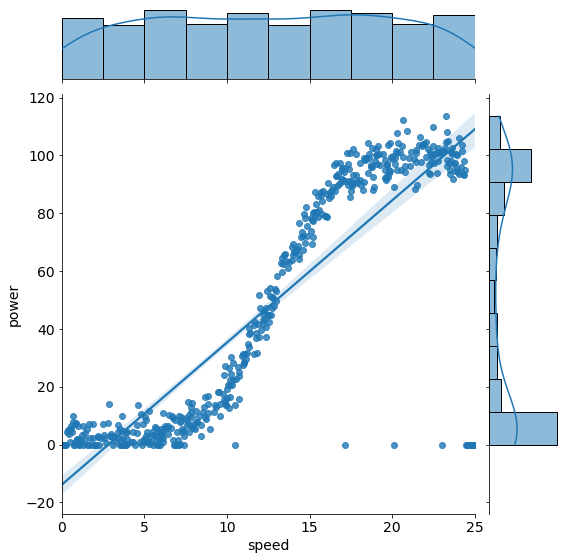

In [169]:
# Visualise dataset
sns.jointplot(data=df, x="speed", y="power",kind="reg", height=8)
#sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

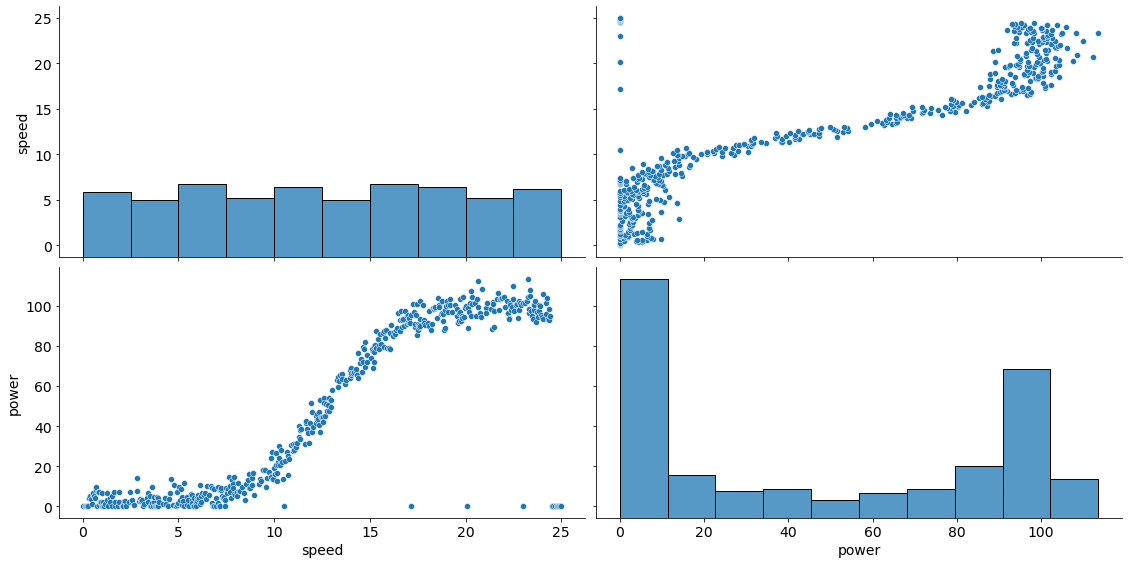

In [170]:
sns.pairplot(df, height=4, aspect=2);

The above shows us  that it is not a typical linear relationship between speed  and power. It appears to follow a polynomial pattern. It shows that while the wind speed is below 10 m/s th epower generation remains low. From 10 to around 18 m/s there is a much faster growth of power generation before peaking out around the 100% mark at about 18  m/s wind speed where it remains until the wind speed reaches 24.5 m/s when an automatic cut off takes effect dropping power generation to 0.

We can also see that there are several 0 values taken for the power generation at various speeds. This could be due to a malfunction or maintenance period on the turbine itself so these will need to be removed before moving forward to determine an accurate algorithm. 

##  Clean Data

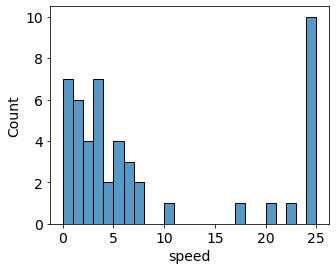

In [171]:
#  Check were majority of readings for 0 power generation values are located. 
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

It appears the vast majority of the 0 readings are at both the low and high ends. From our inital look at the head and tail of the data we can see that the power generation doesn't start until 0.325 m/s wind speed and cuts out from 24.499 m/s wind speed. We will now  use this infomration to remove all values of 0 above the 0.325 value assuming that this is due to a malfunction or a maintenance period and therefore should not have any influence on our alogrithm generation as it is an independent event that has no bearing on the data. The high end cut off also needs to be removed to ensure accuracy in our prerdictions.

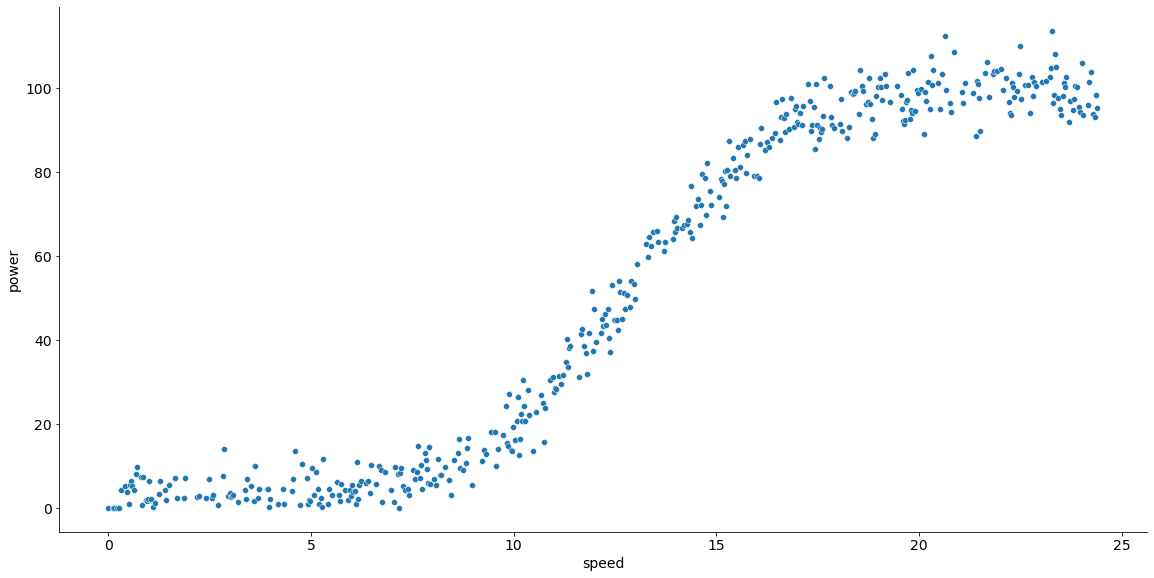

In [172]:
# https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
df = df.drop(df[(df.speed >= 0.325) & (df.power == 0.0)].index)

sns.relplot(data=df, x="speed", y="power", height=8, aspect=2)

(456, 2)

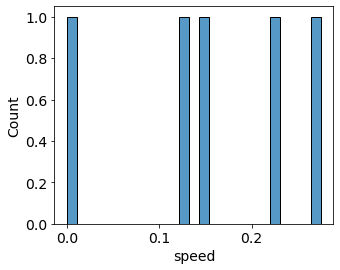

In [173]:
# Check dataframe for locations of remaining 0 values
df_check= df[df['power'] == 0]

sns.histplot(data=df_check, x="speed", bins=25);

df.shape

We can see form  the above that all 0 values between 0.325 m/s and 24.499 m/s have been removed as intended. This brings our dataframe size from 500 rows to 466 rows for a total of 34 rows removed. We can now work with this dataframe to begin to determine the correct algorithm.

## Linear Regression



Looking at the graphs provided we will explore the possibility of fitting a linear regression line onn to the graph. I believe this will not lead to an accurate predictor model but afterwards we can look at polynomial lines to make the fit more suitable.

## Stats Models OLS Regression Model

In [174]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

x = df.speed.to_numpy()
y = df.power.to_numpy()

results = sm.OLS(y, x).fit()

print(results.summary())

print('Parameters: ', results.params)
print('R2: ', results.rsquared)


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.944
Method:                 Least Squares   F-statistic:                              7639.
Date:                Fri, 01 Jan 2021   Prob (F-statistic):                   1.49e-286
Time:                        21:27:52   Log-Likelihood:                         -1904.7
No. Observations:                 456   AIC:                                      3811.
Df Residuals:                     455   BIC:                                      3815.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [175]:
ypred = results.predict()
print('Predicted values: ', ypred)

Predicted values:  [  0.           0.5528806    0.66345673   0.99518509   1.21633733
   1.43748957   1.76921793   1.99037018   2.21594546   2.32652158
   2.4370977    2.54767383   2.76882607   2.98997831   3.10055443
   3.54285891   3.65343503   3.76401116   4.09573952   4.20631564
   4.31689176   4.42746788   4.64862012   4.86977236   5.09092461
   5.53322909   5.64380521   6.19668582   6.30726194   6.64341334
   7.30687007   7.52802231   8.30205516   8.41263128   9.62896861
   9.85012085  10.6241537   10.95588206  11.29203347  11.40260959
  11.95549019  12.5083708   12.61894692  13.0612514   13.28240364
  13.39297976  13.50355589  13.61413201  14.16701261  14.94104546
  15.05162158  15.1621977   15.60892523  15.94065359  16.05122971
  16.38295807  16.4935342   17.26756704  17.37814316  17.48871928
  17.5992954   18.48390437  19.03678498  19.1473611   20.03639311
  20.14696923  20.36812147  20.92100208  21.14215432  21.69503492
  21.80561104  21.91618716  22.02676329  22.24791553  22.

[  0.           1.07225329   2.14450659   3.21675988   4.28901317
   5.36126647   6.43351976   7.50577306   8.57802635   9.65027964
  10.72253294  11.79478623  12.86703952  13.93929282  15.01154611
  16.08379941  17.1560527   18.22830599  19.30055929  20.37281258
  21.44506587  22.51731917  23.58957246  24.66182575  25.73407905
  26.80633234  27.87858564  28.95083893  30.02309222  31.09534552
  32.16759881  33.2398521   34.3121054   35.38435869  36.45661199
  37.52886528  38.60111857  39.67337187  40.74562516  41.81787845
  42.89013175  43.96238504  45.03463833  46.10689163  47.17914492
  48.25139822  49.32365151  50.3959048   51.4681581   52.54041139
  53.61266468  54.68491798  55.75717127  56.82942457  57.90167786
  58.97393115  60.04618445  61.11843774  62.19069103  63.26294433
  64.33519762  65.40745092  66.47970421  67.5519575   68.6242108
  69.69646409  70.76871738  71.84097068  72.91322397  73.98547726
  75.05773056  76.12998385  77.20223715  78.27449044  79.34674373
  80.418997

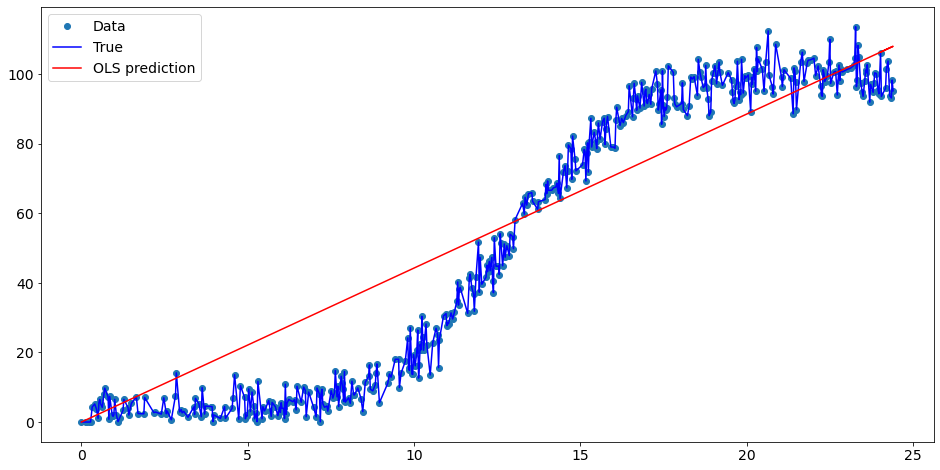

In [176]:
x1n = np.linspace(0, 24, 100)
Xnew = x1n.reshape(-1, 1)


ynewpred =  results.predict(Xnew) # predict out of sample
print(ynewpred)

fig, ax = plt.subplots()
ax.plot(df.speed, df.power, 'o', label="Data")
ax.plot(df.speed, df.power, 'b-', label="True")
ax.plot(np.hstack((df.speed, x1n)), np.hstack((ypred, ynewpred)), 'r', label="OLS prediction")
ax.legend(loc="best");

***

In [199]:
y = df.power.to_numpy() 
x = df.speed.to_numpy().reshape(-1, 1) # reshape called as array is required to be two-dimensional

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

print('intercept:', model.intercept_)

print('slope:', model.coef_)


coefficient of determination: 0.8980963337957819
intercept: -18.91990602389771
slope: [5.56364725]


In [178]:
test=[[21.396]] # Actual answer 88.544 Returns 100.1198906
test2=[[14.84]] # Actual answer 75.466 Returns 63.64461921
test3=[[7.708]] # Actual answer 10.297 Returns 23.964687

y_pred = model.predict(test3)
print('predicted response:', y_pred, sep='\n')

predicted response:
[23.964687]


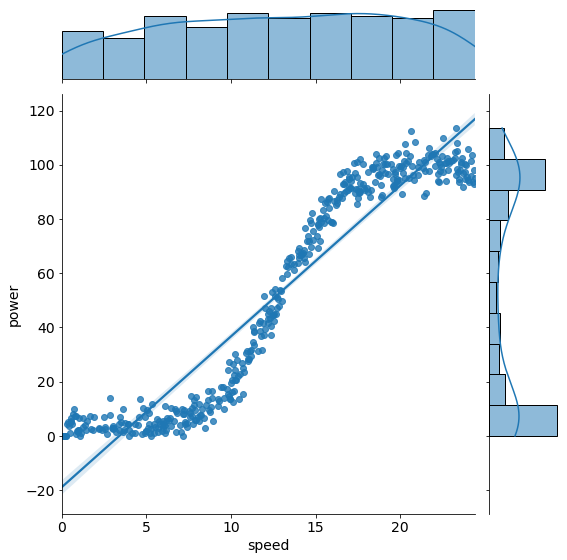

In [179]:
sns.jointplot(data=df, x="speed", y="power",kind="reg", height= 8)

## Polynomial Regression

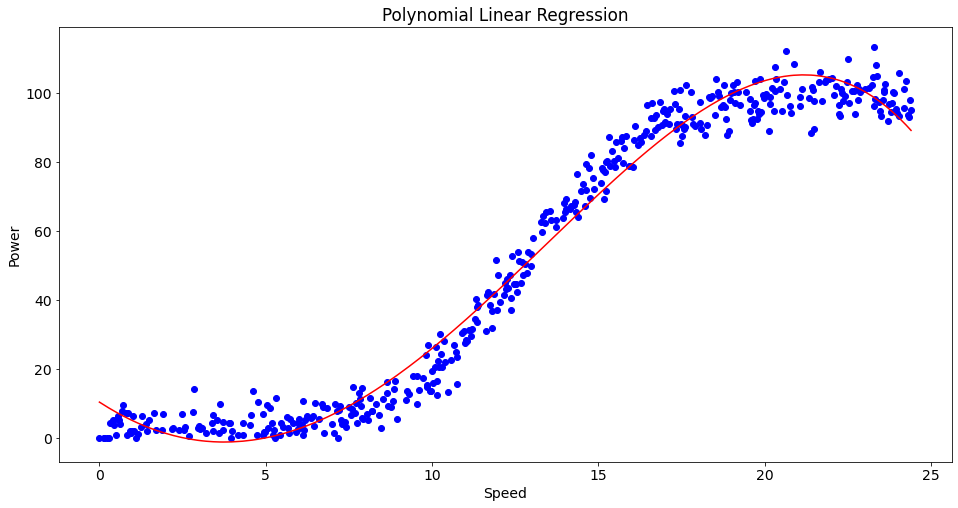

In [187]:
# Fitting Polynomial Regression to the dataset. https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(x)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)

# Visualizing the Polymonial Regression results
def viz_polymonial():
    plt.scatter(x, y, color='blue')
    plt.plot(x, pol_reg.predict(poly_reg.fit_transform(x)), color='red')
    plt.title('Polynomial Linear Regression')
    plt.xlabel('Speed')
    plt.ylabel('Power')
    plt.show()
    return
viz_polymonial()

In [230]:
# Predicting a new result with Polymonial Regression
print(pol_reg.predict(poly_reg.fit_transform([[1.001]]))) # 6.511
print(pol_reg.predict(poly_reg.fit_transform([[4.980]]))) # 1.681
print(pol_reg.predict(poly_reg.fit_transform([[10.085]]))) # 20.709
print(pol_reg.predict(poly_reg.fit_transform([[15.140]]))) # 77.725
print(pol_reg.predict(poly_reg.fit_transform([[20.170]]))) # 96.963

[5.06372441]
[0.06063657]
[26.70563282]
[71.92838726]
[104.13748836]


## Sources

https://www.geeksforgeeks.org/working-with-missing-data-in-pandas/#:~:text=In%20order%20to%20check%20missing,null%20values%20in%20a%20series.

https://realpython.com/linear-regression-in-python/

https://www.statsmodels.org/stable/index.html